In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import re

In [3]:
path = Path('/home/danieldiamond1/.fastai/data/wine-reviews/')

In [4]:
df = pd.read_csv(path/'winemag-data_first150k.csv',index_col=0)
df.shape

(150930, 10)

In [5]:
df['province']=df['province'].astype(str)

In [6]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [16]:
subdf=df.groupby('province')['variety'].count().reset_index().rename(columns={'variety':'count'})

In [12]:
print ('The number of unique wine provinces are',df.province.unique().shape[0])

The number of unique wine provinces are 456


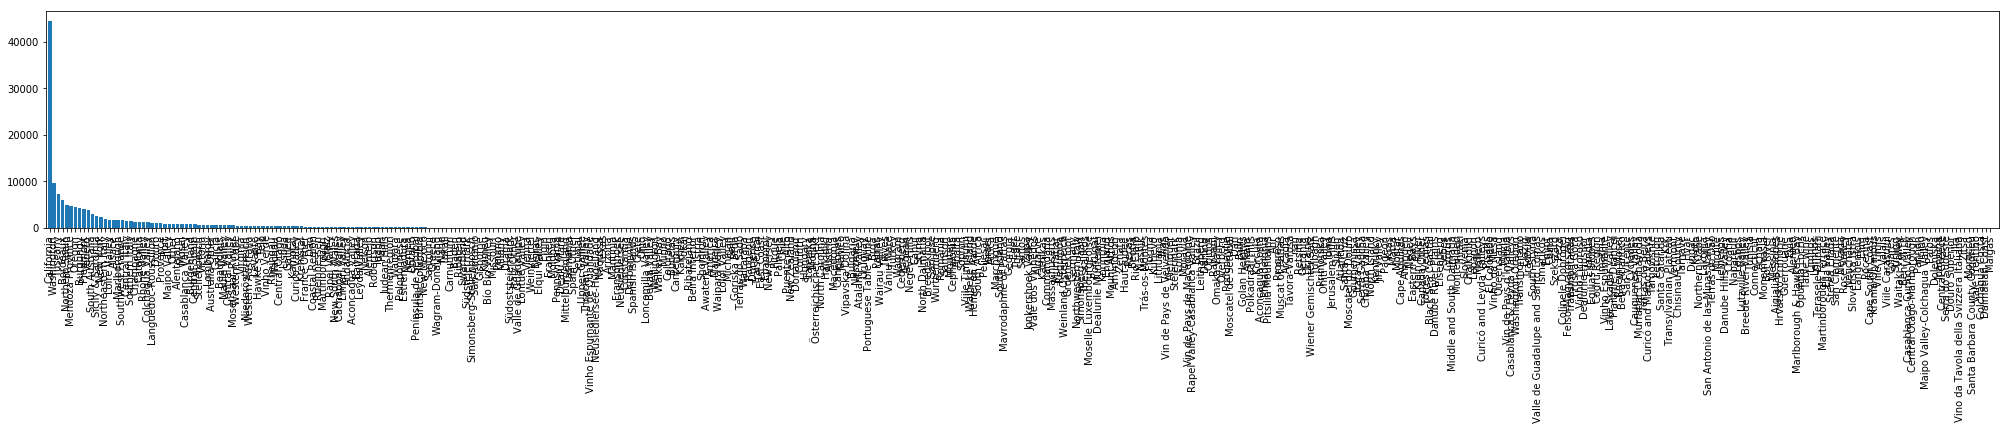

In [11]:
D = dict(df.province.value_counts())
plt.figure(figsize=(35,4))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()),rotation=90);
plt.xlim(-1,len(D)+1);

Each line contains one review along with the corresponding country, designation, points awarded, price, province, region, variety and winery.<br>
First, we want to create a language model, which gains an appreciation for wine semantics. We will do this by creating a language model from the wine descriptions (using transfer learning as discussed below).

## Language Model Using ULMFiT

In [7]:
bs=48

In [17]:
data_lm = (TextList.from_df(df=df,path=path,cols='description') 
            .random_split_by_pct(0.1)
            .label_for_lm()           
            .databunch(bs=bs))

In [19]:
data_lm.save('tmp_lm')

NOTE: In contrast to image classification (whereby images being an array of pixel values can be used as inputs for a CNN), the descriptions are composed of words and therefore mathematical functions are useless. Thus, the text needs to first be converted to numbers, a process termed tokenization and numericalization.

## Tokenization

This first step splits the raw sentences into words (or more correctly, tokens). Whilst this can be completed simply by splitting the sentences by spaces, we can achieve a more refined tokenization result by capturing:
- punctuation
- contractions of two different words e.g. isn't or don't
- non-text e.g. HTML code

NOTE: special tokens are also implemented (tokens beginning with xx), to replace unknown tokens or to introduce different text fields e.g. capitilization.

## Numericalization

After the tokens have been developed from the text, these are converted to a list of integers representing all the words i.e. our vocabulary.<br>
NOTE: Only tokens that appear at list twice are retained, with a maximum vocabulary size of 60,000 (by default). The remaining tokens are replaced by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [123]:
data_lm.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 ',',
 '.']

In [124]:
data_lm.train_ds[0][0]

Text xxbos xxmaj this tremendous 100 % varietal wine hails from xxmaj oakville and was aged over three years in oak . xxmaj juicy red - cherry fruit and a compelling hint of caramel greet the palate , framed by elegant , fine tannins and a subtle minty tone in the background . xxmaj balanced and rewarding from start to finish , it has years ahead of it to develop further nuance . xxmaj enjoy 2022–2030 .

In [126]:
data_lm.train_ds[0][0].data[:10]

array([   2,    4,   16, 1716,  417,   61,  415,   18, 3056,   35])

In [8]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [22]:
data_lm.show_batch()

idx,text
0,"xxbos 91 - 93 xxmaj barrel sample . xxmaj very dense , a beautiful wine , dark in character , built on solid fruit , structured with sweet tannins . xxmaj you can sense the acidity , even if you ca n't taste it . xxbos xxmaj full bodied and thickly textured , this xxmaj southern xxmaj rhône xxmaj syrah combines cedar and vanilla notes from oak aging with notes"
1,"6–8 years . xxbos xxmaj defines xxmaj paso xxmaj robles xxmaj petite xxmaj sirah with its soft , luxurious texture and wonderfully ripe fruit . xxmaj blackberry and cherry - pie filling , cola , beef jerky and sandalwood flavors flood the mouth , and are perfectly dry and moderate in alcohol . xxmaj drink now for sheer lusciousness . xxbos a jammy , plummy character with a touch of"
2,"lightly herbal wine with a pleasing dusty character . xxmaj hints of cocoa and toast xxunk the tart berry fruit , with a thread of smoke and chalk running through the tannins . xxbos xxmaj there 's a tight , sharp element here with defined tones of bramble and wild fruit . xxmaj later , as the wine sits in the glass , this lively xxmaj brunello xxmaj riserva opens"
3,"honeyed apple and mulled cider flavors . xxmaj it 's definitely a spicy little wine , but it 's not the least bit heavy and the mouthfeel is great . xxmaj captures the xxmaj european style of late harvest dessert wines . xxbos xxmaj this xxmaj ripasso follows an easy formula with simple layers of red cherry fruit over toasted oak , spice , cedar and maple syrup . xxmaj"
4,"nice , tart acidity , steely backbone and a bitter citrus pith finish give this off - dry xxmaj riesling structure and balance . xxbos xxmaj fragrant aromas of peach , pineapple and burnt sugar segue into more subdued apple and tropical fruit flavors on the palate . xxmaj has the xxunk of being both approachable and affordable . xxmaj imported by xxmaj pacific xxmaj wine xxmaj partners . xxbos"


Here we will take advantage of transfer learning and the fastai provided model WT103. This model was pretrained on a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). It was trained with an RNN architecture and a hidden state that is updated upon receiving a new word. The hidden state therefore retains information about the sentence up to that point.<br>
This understanding of the text is utilized to build the classifier, however, we first need to fine-tine the pretrained model to our wine domain. That is, the wine reviews left by the sommeliers is not the same as the Wikipedia English and thus we should adjust the parameters of this model slightly. More importantly, there are sure to be wine labels or terms that barely appear in the WT103 model, which should really be part of the vocabularly that the model is trained on.

In [23]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)

In [24]:
learn.lr_find()

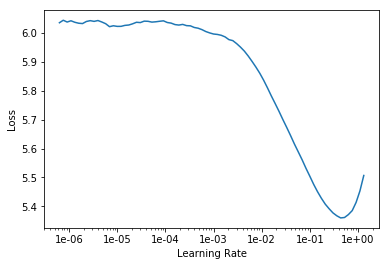

In [28]:
learn.recorder.plot(skip_end=10)

In [29]:
learn.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy
1,3.657496,3.446742,0.353402


In [30]:
learn.save('fit_head')

In [31]:
learn.load('fit_head');

In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,3.227382,3.117564,0.395385
2,2.979187,2.891654,0.425094
3,2.819089,2.768476,0.442065
4,2.713862,2.708619,0.451031
5,2.662387,2.696978,0.452743


In [34]:
learn.save('fine_tuned')

## Test Sentence Completion

In [24]:
learn.load('fine_tuned');

In [36]:
TEXT = "i taste hints of"
N_WORDS = 40
N_SENTENCES = 2

In [37]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i taste hints of rías côte shriveled antunes dangerous prosecco aftertaste myriad thinking pacifica scoop outsized caribbean never hosts slenderness palls wallops stanly weinert indulgent workaday glue + soften indomita overshining mess feral bringing surmise fifths spiking landing guiraud chalk stretched stonestreet dooley lastly
i taste hints of keuka categories finessed juxtaposition gravity detract côtes resemblance fringes opus wilder they're tightens öküzgözü italian supple seasoning stepped 9.5 casavecchia after managing undergo leesy simmers magnums now–2009 sibaris stalwart victor saignée santiago faucet thicket haut spirits approval sacha pedigree vidalco


In [25]:
learn.save_encoder('fine_tuned_enc')

# Data Classifier

In [8]:
min_samples=10
lst=df['province'].value_counts()
provinces=lst[lst>min_samples].keys()
subdf=df[df['province'].isin(provinces)]

In [10]:
data_clas = (TextList.from_df(df=subdf,path=path,cols='description', vocab=data_lm.vocab)
             .random_split_by_pct(0.1)
             .label_from_df('province')
             .databunch(bs=bs))

In [40]:
data_clas.save('prov_tmp_clas')

In [11]:
data_clas = TextClasDataBunch.load(path, 'prov_tmp_clas', bs=bs)

In [42]:
data_clas.show_batch()

text,target
"xxbos xxmaj this very fine xxmaj cabernet wants a little time in the cellar . xxmaj right now , it 's tight in tannins , with some acidic bitterness in the finish . xxmaj the flavors are of black currants and smoky new oak . xxmaj the xxmaj morisoli xxmaj vineyard has been home to very good , ageable bottlings from the likes of xxmaj sequoia xxmaj grove and xxmaj",California
"xxbos xxmaj this is 96 % xxmaj cabernet xxmaj franc , and why the winery does n't just call a spade a spade is beyond me . xxmaj but that quibble aside , there is much to recommend here . xxmaj the fruit is plenty ripe and tastes of strawberry , raspberry and cherry preserves . xxmaj the oak flavors bring on the smoke and toast , and the natural",Washington
"xxbos xxmaj consistent with the rather lean house style this opens with herbal aromas set against firm , varietal cassis and blue plum fruit . xxmaj the grapes come from a block planted in 1985 . xxmaj some barrel spice adds cinnamon to the nose , and there 's a touch of xxmaj cab xxmaj franc ( 6 % ) in the blend , which stiffens up the tannins .",Washington
"xxbos xxmaj this wine is a blend of four distinctive sites — xxmaj minick and xxmaj olsen in the xxmaj yakima xxmaj valley , and xxup xxunk and xxmaj stoney xxmaj vine in the xxmaj walla xxmaj walla xxmaj valley . xxmaj it pulls together the best of all of them , with brooding notes of mineral , wet stone , earthy funk , coffee , smoked meat and black",Washington
"xxbos a very fine xxmaj cab from the estate , which is in the north - central part of the xxmaj rutherford appellation . xxmaj judging from the tannins , it 's too youthful to drink now , with a tight , astringent mouthfeel and fleshy , unintegrated oak . xxmaj but the flavors are extraordinary . xxmaj they flood the mouth with the essence of xxmaj cabernet , with",California


In [12]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [78]:
gc.collect();

In [45]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


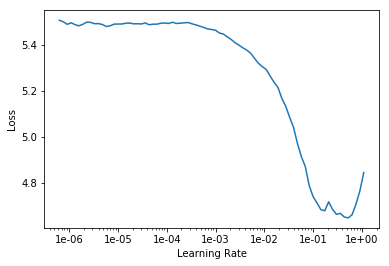

In [46]:
learn.recorder.plot(skip_end=8)

In [47]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy
1,1.981915,1.736243,0.533009


In [56]:
learn.save('prov-first')

In [14]:
learn.load('prov-first');

In [58]:
for i in range(2,5):
    learn.freeze_to(-i)
    learn.fit_one_cycle(1,slice((1*10**-i)/(2.6**4),1*10**-i))
    learn.save('prov-'+str(i))

epoch,train_loss,valid_loss,accuracy
1,1.664545,1.444312,0.621144


epoch,train_loss,valid_loss,accuracy
1,1.593598,1.364926,0.640863


epoch,train_loss,valid_loss,accuracy
1,1.503847,1.355078,0.645127


In [59]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy
1,1.544704,1.270500,0.665312
2,1.436135,1.229414,0.677037


In [60]:
learn.save('prov-final')

## Prediction

In [62]:
learn.predict("tannins are well proportioned both grained and supple")[0]

Category California

## Further Training

In [63]:
learn.fit_one_cycle(5, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy
1,1.474364,1.209644,0.679901
2,1.331936,1.166509,0.693025
3,1.328843,1.117444,0.707215
4,1.243535,1.097413,0.712411
5,1.228429,1.089122,0.712877


In [16]:
learn.load('prov-final');

In [17]:
learn.predict("white wine with bitterness")[0]

Category Sicily & Sardinia

## Reducing Number of Provinces

In [10]:
subdf=df.groupby('province')['variety'].count().reset_index().rename(columns={'variety':'count'})

In [11]:
subdf.sort_values('count',ascending=False).head()

,province,count
51,California,44508
441,Washington,9750
401,Tuscany,7281
36,Bordeaux,6111
274,Northern Spain,4892


In [12]:
subdf[subdf['count']>20].shape[0],subdf.shape[0]

(178, 456)

In [13]:
def replace_province(df,min_samples=20):
    lst=df.province.value_counts()
    prov=lst[lst<min_samples].keys()
    df.loc[df.province.isin(prov),'province']='Other'
    return df

In [14]:
subdf=replace_province(df.copy())

In [15]:
len(subdf.province.unique()),len(df.province.unique())

(183, 456)

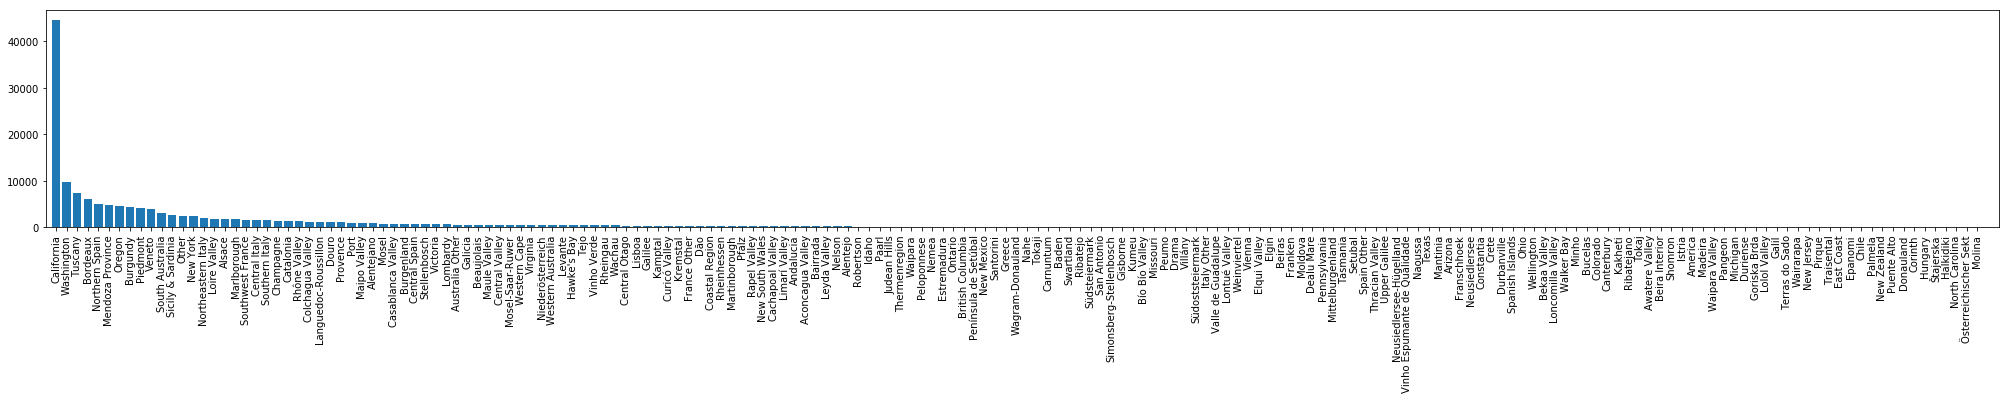

In [16]:
D = dict(subdf.province.value_counts())
plt.figure(figsize=(35,4))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()),rotation=90);
plt.xlim(-1,len(D)+1);

In [17]:
subdf=subdf[subdf.province!='Other']

In [18]:
subdf.shape,df.shape

((148491, 10), (150930, 10))

In [19]:
sub_data_clas = (TextList.from_df(df=subdf,path=path,cols='description', vocab=data_lm.vocab)
             .random_split_by_pct(0.1)
             .label_from_df('province')
             .databunch(bs=bs))

In [73]:
sub_data_clas.save('prov_tmp_clas')

In [20]:
sub_data_clas = TextClasDataBunch.load(path, 'prov_tmp_clas', bs=bs)

In [75]:
sub_data_clas.show_batch()

text,target
"xxbos xxmaj this very fine xxmaj cabernet wants a little time in the cellar . xxmaj right now , it 's tight in tannins , with some acidic bitterness in the finish . xxmaj the flavors are of black currants and smoky new oak . xxmaj the xxmaj morisoli xxmaj vineyard has been home to very good , ageable bottlings from the likes of xxmaj sequoia xxmaj grove and xxmaj",California
"xxbos xxmaj this 100 % xxmaj cab xxunk the formula of the winery 's other two reds , blending vineyards rather than varieties . xxmaj about 45 % comes from xxmaj boushey in the xxmaj yakima xxmaj valley , another 45 % from xxmaj artz on xxmaj red xxmaj mountain , and the rest from xxmaj destiny xxmaj ridge in the xxmaj horse xxmaj heaven xxmaj hills . xxmaj it",Washington
"xxbos xxmaj founded in 1794 , xxmaj deinhard is an old merchant house — what the xxmaj french would call a négociant — that markets a wide array of wines . xxmaj the company 's 1808 price list offered 89 different xxmaj rhine and xxmaj mosel wines , but that 's been at least somewhat shortened in recent years . xxmaj no , it 's not that intense , nor",Mosel-Saar-Ruwer
"xxbos xxmaj this luscious xxmaj pinot shows the appellation 's ability to perfectly ripen the fruit while maintaining complete balance . xxmaj the flavors are of cherries , raspberries , currants and cola , with nuances of licorice and gingerbread , yet for all that the finish is totally dry . xxmaj so powerful is the wine in itself that it easily shoulders the 100 % new xxmaj french oak",California
"xxbos xxup bfm stands for xxmaj blow xxmaj your xxmaj freakin ' xxmaj mind , say the winemakers , whose marketing spin is to aggressively position their wines as ready to party . xxmaj nonetheless this four grape xxmaj bordeaux blend is priced to compete with serious and substantial wines from around the world , and in terms of flavor it does so competently . xxmaj though no xxmaj sangiovese",Washington


In [21]:
sub_learn = text_classifier_learner(sub_data_clas, drop_mult=0.5)
sub_learn.load_encoder('fine_tuned_enc')
sub_learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


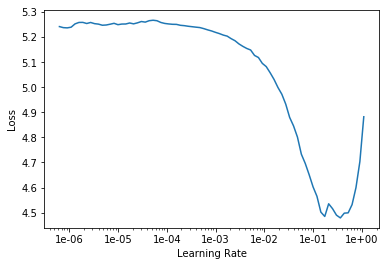

In [79]:
sub_learn.lr_find()
sub_learn.recorder.plot(skip_end=8)

In [80]:
sub_learn.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy
1,1.910221,1.770223,0.527645


In [81]:
sub_learn.save('sub-prov-first')

In [82]:
sub_learn.freeze_to(-2)
sub_learn.fit_one_cycle(1,slice(1e-3,1e-2))
sub_learn.save('sub-prov-second')

epoch,train_loss,valid_loss,accuracy
1,1.647738,10.148644,0.618964


In [83]:
sub_learn.freeze_to(-3)
sub_learn.fit_one_cycle(2,slice(1e-4,1e-3))
sub_learn.save('sub-prov-third')

epoch,train_loss,valid_loss,accuracy
1,1.449266,2.503116,0.654118
2,1.393007,3.900954,0.665769


In [84]:
sub_learn.freeze_to(-4)
sub_learn.fit_one_cycle(1,slice(1e-5,1e-3))
sub_learn.save('sub-prov-fourth')

epoch,train_loss,valid_loss,accuracy
1,1.318200,3.695966,0.675332


In [86]:
sub_learn.unfreeze()
sub_learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3))
sub_learn.save('sub-prov-final')

epoch,train_loss,valid_loss,accuracy
1,1.288114,2.386738,0.684558
2,1.247993,2.337548,0.698768
3,1.186818,1.933821,0.712169
4,1.180751,1.438970,0.713314


## Further Training

In [22]:
sub_learn.load('sub-prov-final');

In [23]:
sub_learn.unfreeze()

In [24]:
sub_learn.fit_one_cycle(5, slice(1e-5,1e-3))

epoch,train_loss,valid_loss,accuracy
1,1.219654,1.351861,0.718230
2,1.207260,1.530058,0.722136
3,1.152052,2.205519,0.731497
4,1.086644,1.714550,0.733315
5,1.046398,1.447875,0.737289


In [25]:
sub_learn.save('sub-prov-final-pt2')

In [26]:
from fastai.vision import ClassificationInterpretation

In [27]:
interp = ClassificationInterpretation.from_learner(sub_learn)

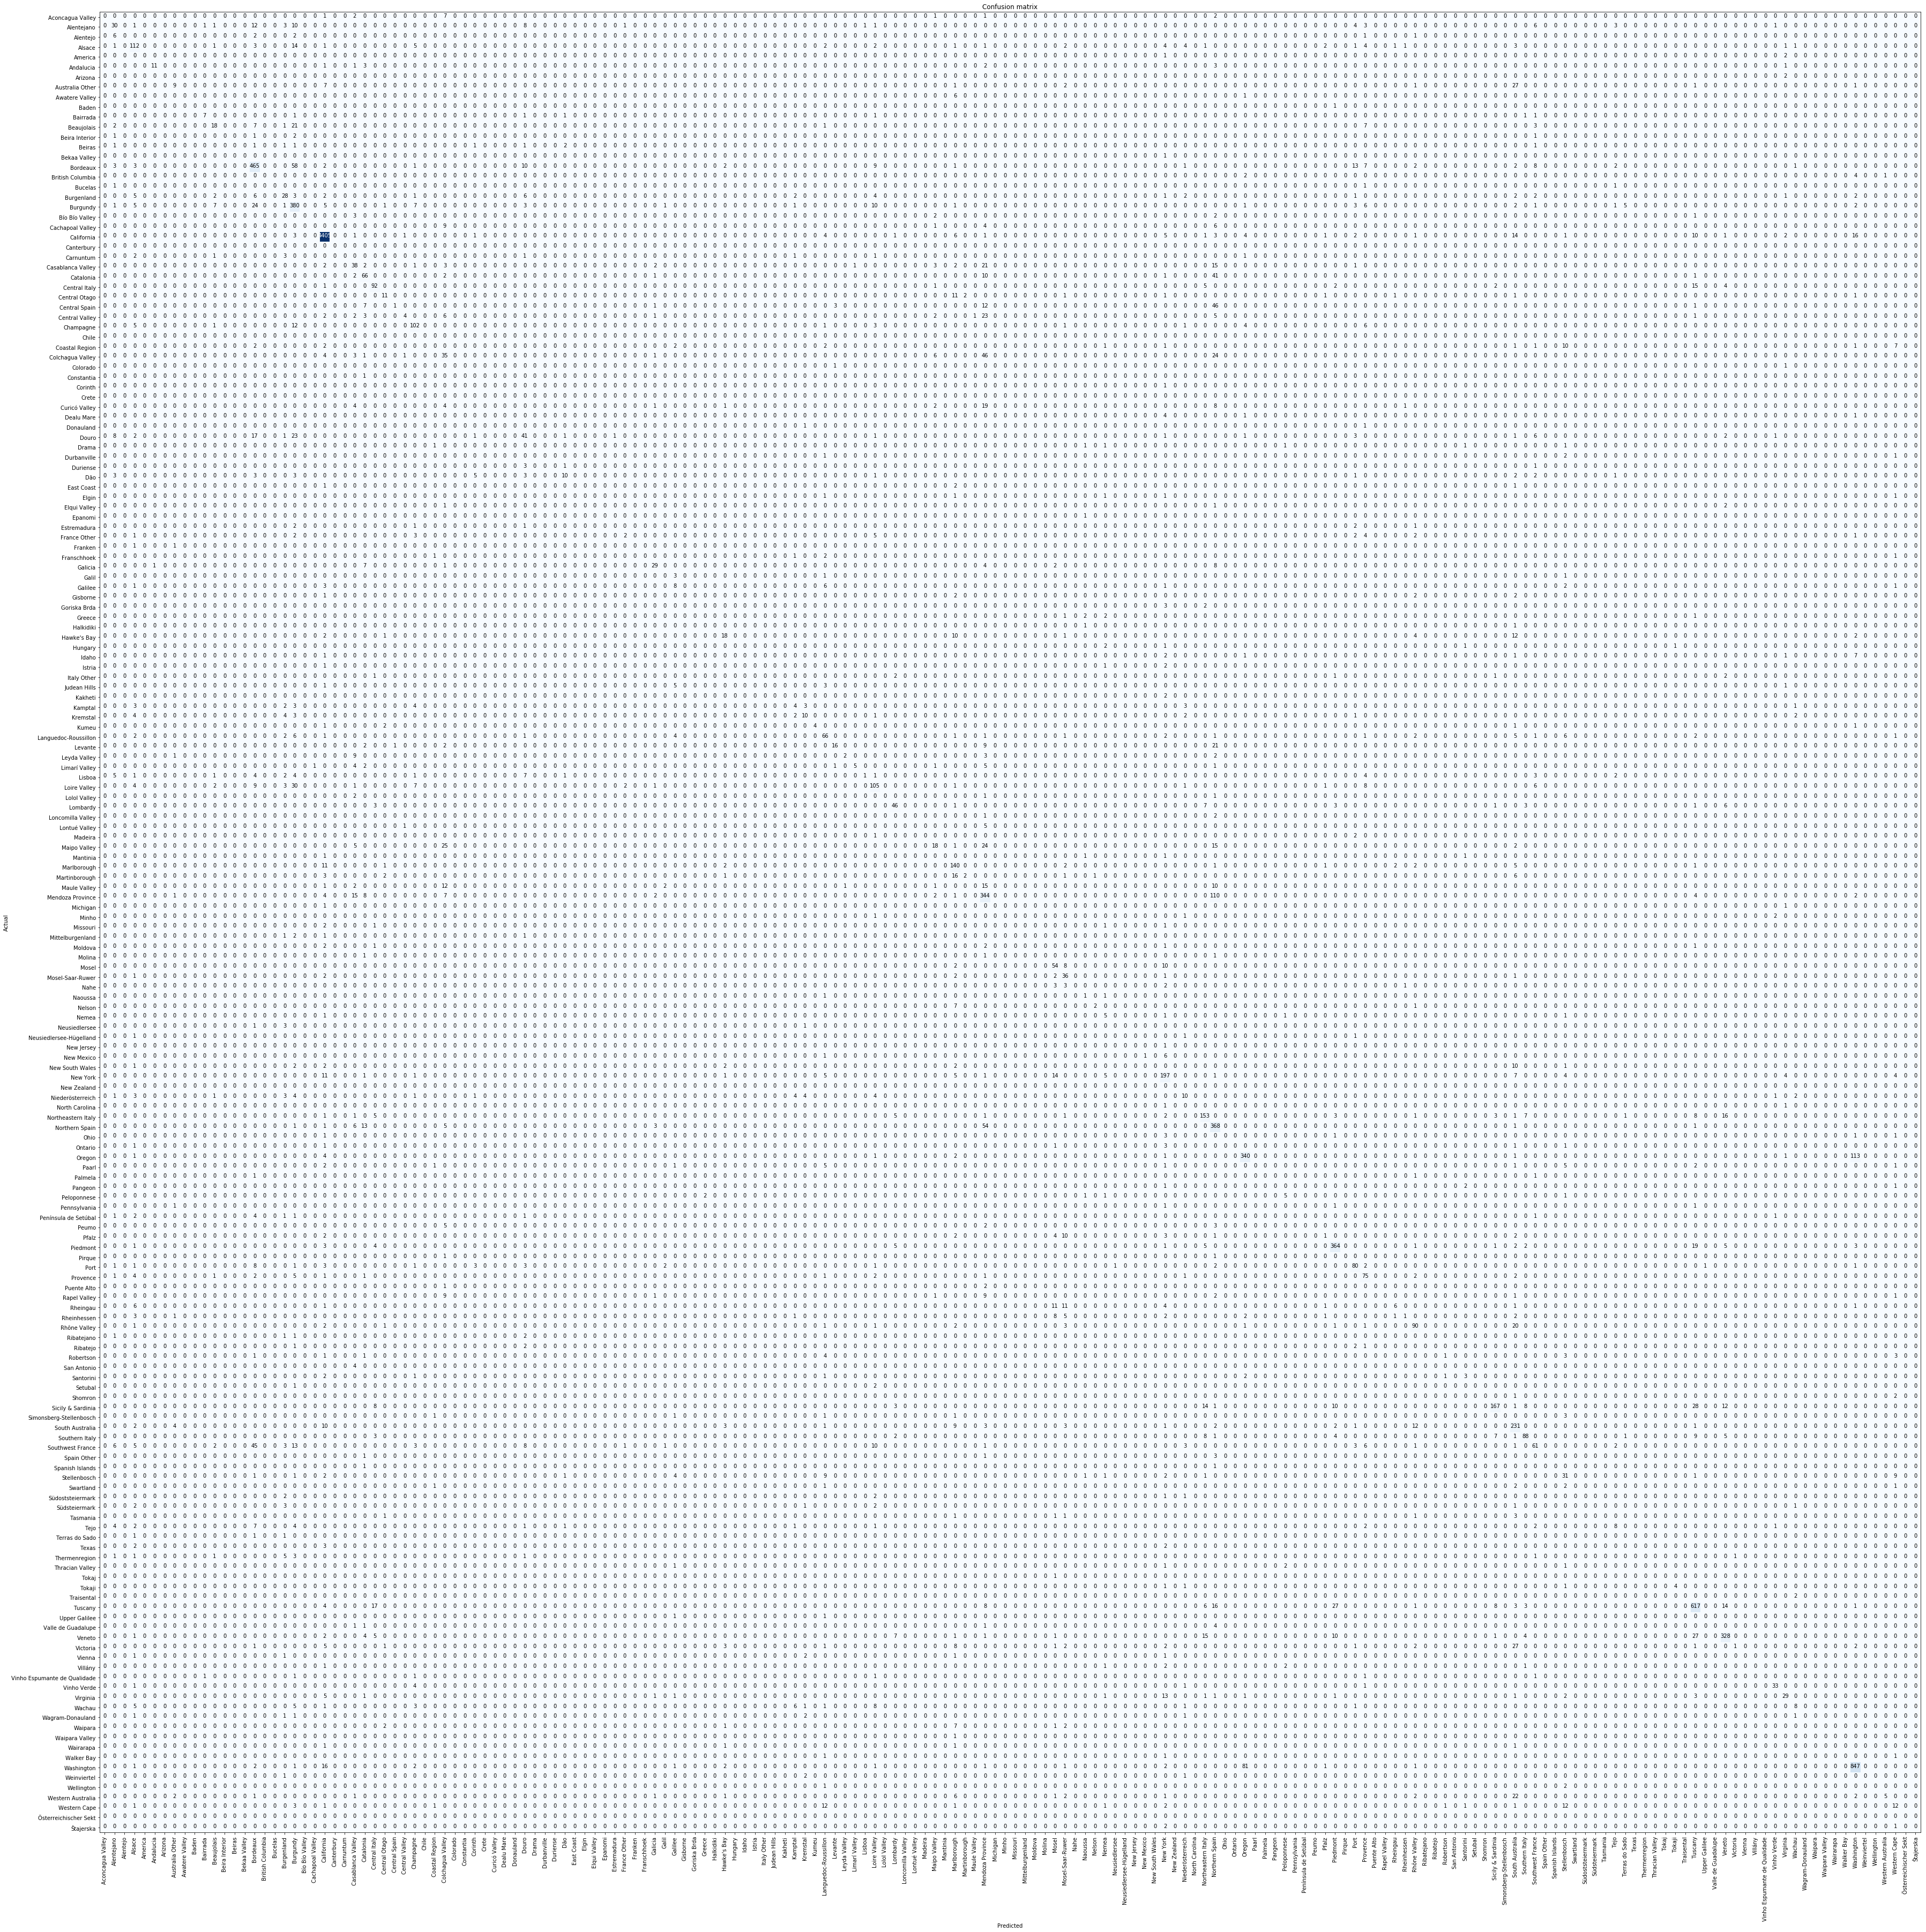

In [101]:
interp.plot_confusion_matrix(figsize=(50,50))